# Chains in LangChain

Chains allow us to combine multiple components together to create a single, coherent application. For example, we can create a chain that takes user input, formats it with a PromptTemplate, and then passes the formatted response to an LLM.

## Outline

* LLMChain
* Sequential Chains
  * SimpleSequentialChain
  * SequentialChain
* Router Chain

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

Note: LLM's do not always produce the same results. When executing the code in your notebook, you may get slightly different answers that those in the video.

In [3]:
# account for deprecation of LLM model
import datetime
# Get the current date
current_date = datetime.datetime.now().date()

# Define the date after which the model should be set to "gpt-3.5-turbo"
target_date = datetime.date(2024, 6, 12)

# Set the model variable based on the current date
if current_date > target_date:
    llm_model = "gpt-3.5-turbo"
else:
    llm_model = "gpt-3.5-turbo-0301"

In [4]:
#!pip install pandas

In [5]:
import pandas as pd
df = pd.read_csv('Data.csv')

In [6]:
df.head()

,Product,Review
0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...
1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi..."
2,Luxury Air Mattress,This mattress had a small hole in the top of i...
3,Pillows Insert,This is the best throw pillow fillers on Amazo...
4,Milk Frother Handheld\n,I loved this product. But they only seem to l...


## LLMChain

In [7]:
#LLM
from langchain.chat_models import ChatOpenAI
#Chatprompt template
from langchain.prompts import ChatPromptTemplate
#LLMChain
from langchain.chains import LLMChain

In [8]:
#high temperature for fun descriptions
llm = ChatOpenAI(temperature=0.9, model=llm_model)

In [9]:
prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

In [10]:
chain = LLMChain(llm=llm, prompt=prompt)

In [11]:
product = "Queen Size Sheet Set"
chain.run(product)

'Royal Comforts.'

## Sequential Chain 

The next step after calling a language model is to make a series of calls to a language model. 

This is particularly useful when you want to take the output from one call and use it as the input to another.

The recommended way to do this is using the LangChain Expression Language. The legacy way is using the SequentialChain

## SimpleSequentialChain

The simplest form of sequential chains, where each step has a singular input/output, and the output of one step is the input to the next.

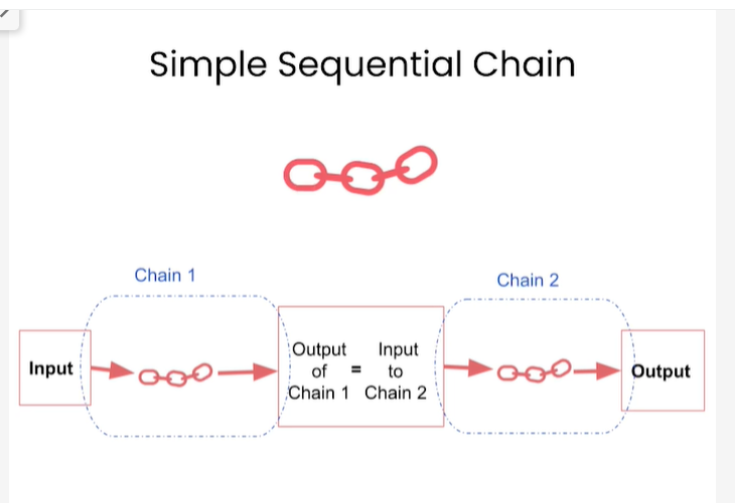

In [12]:
#Works well when we have subchains that expect only one inout and return only one output.
from langchain.chains import SimpleSequentialChain

In [13]:
llm = ChatOpenAI(temperature=0.9, model=llm_model)

# prompt template 1 - For company name
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

# Chain 1 - For company name
chain_one = LLMChain(llm=llm, prompt=first_prompt)

In [14]:
# prompt template 2 - For 20 word company description
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the following \
    company:{company_name}"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt)

In [15]:
#Combines the 2 chains
overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two],
                                             verbose=True
                                            )

In [16]:
overall_simple_chain.run(product)



> Entering new SimpleSequentialChain chain...
Royal Beddings
Royal Beddings offers high-quality and luxurious bedding sets, comforters, duvet covers, and pillowcases to ensure a peaceful and comfortable sleep.

> Finished chain.


'Royal Beddings offers high-quality and luxurious bedding sets, comforters, duvet covers, and pillowcases to ensure a peaceful and comfortable sleep.'

## SequentialChain

Of course, not all sequential chains will be as simple as passing a single string as an argument and getting a single string as output for all steps in the chain. 

In this next example, we will experiment with more complex chains that involve multiple inputs, and where there also multiple final outputs.

Of particular importance is how we name the input/output variables. 

In the above example we didn't have to think about that because we were just passing the output of one chain directly as input to the next, but here we do have worry about that because we have multiple inputs.

We use this when there are multiple inputs or multiple outputs

NOTE: THE INPUT KEYS AND OUTPUT KEYS NEED TO BE VERY PRECISE AS THERE ARE MANY INPUTS AND OUTPUTS. 

THESE ARE TO BE LINED UP PROPERLY AND IF ANY KEY ERRORS OCCUR CHECK THE LINE UP.

EG: 
1ST PROMPT->REVIEW-> ENGLISH REVIEW-> SUMMARY -> USED IN FINAL PROMPT
3RD PROMPT->REVIEW-> LANGUAGE-> USED IN FINAL PROMPT

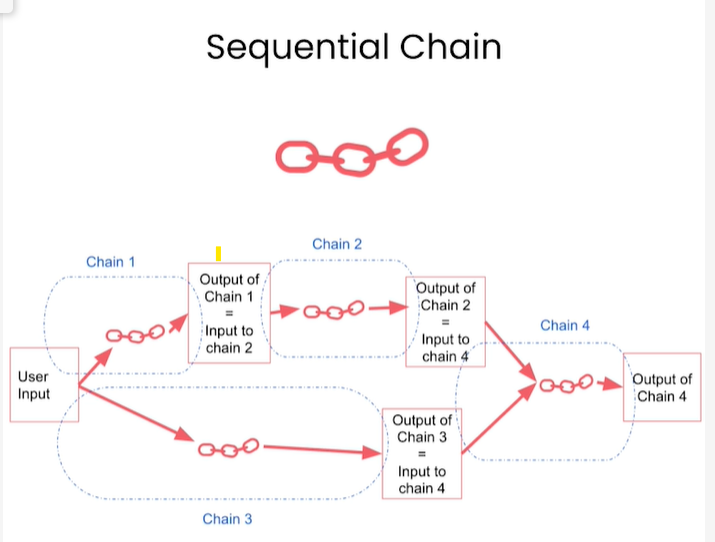

In [17]:
from langchain.chains import SequentialChain

In [18]:
llm = ChatOpenAI(temperature=0.9, model=llm_model)

# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="English_Review"
                    )


In [19]:
second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt, 
                     output_key="summary"
                    )


In [20]:
# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )


In [21]:

# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )


In [22]:
# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["English_Review", "summary","followup_message"],
    verbose=True
)

In [23]:
review = df.Review[5]
overall_chain(review)



> Entering new SequentialChain chain...

> Finished chain.


{'Review': "Je trouve le goût médiocre. La mousse ne tient pas, c'est bizarre. J'achète les mêmes dans le commerce et le goût est bien meilleur...\nVieux lot ou contrefaçon !?",
 'English_Review': "I find the taste mediocre. The foam doesn't hold up, it's weird. I buy the same ones in stores and the taste is much better... Old batch or counterfeit!?",
 'summary': "The reviewer finds the taste of the product mediocre, the foam doesn't hold up, and wonders if it's an old batch or counterfeit.",
 'followup_message': "Réponse: Le critique trouve le goût du produit médiocre, la mousse ne tient pas et se demande s'il s'agit d'un vieux lot ou d'une contrefaçon."}

## Router Chain

Route an input to a chain depending on what exactly that input is.
_______________________________________________________________
Example: 

If we have multiple sub chains, each of which is specialized for a particular type of input.

The router chain will decide which sub chain to pass it to and then passes it to it.
_______________________________________________________________

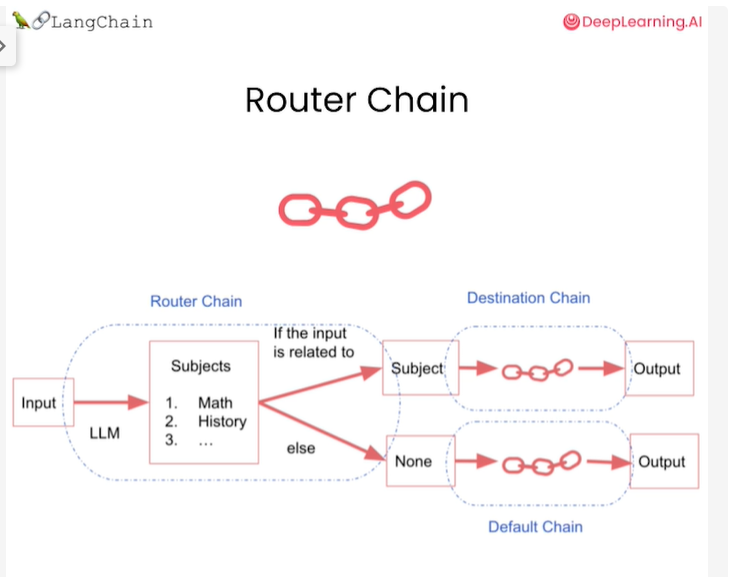

In [24]:
#to answer physics questions
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""

#to answer math questions
math_template = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts, 
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

#to answer history questions
history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""

#to answer computer science questions
computerscience_template = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration,\
forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. \
You are so good because you know how to solve a problem by \
describing the solution in imperative steps \
that a machine can easily interpret and you know how to \
choose a solution that has a good balance between \
time complexity and space complexity. 

Here is a question:
{input}"""

In [25]:
#Here we are giving each one a name and a description.
#This info will be passed to the router chain so that the router chain can decide when to use which sub chain

prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about physics", 
        "prompt_template": physics_template
    },
    {
        "name": "math", 
        "description": "Good for answering math questions", 
        "prompt_template": math_template
    },
    {
        "name": "History", 
        "description": "Good for answering history questions", 
        "prompt_template": history_template
    },
    {
        "name": "computer science", 
        "description": "Good for answering computer science questions", 
        "prompt_template": computerscience_template
    }
]

In [26]:
#to route between multiple different prompt templates
from langchain.chains.router import MultiPromptChain
#LLMRouterChain - uses a router model itself to route between different subchains(uses the name and the description we have provided above)
#RouterOutputParser - parses the LLM output into a dictionary that can be used downstream to determine which chain to use nad what the inout to that chain should be.
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate

In [27]:
llm = ChatOpenAI(temperature=0, model=llm_model)

In [28]:
# Destination chains - the chains that will be called by the router chains which subchain to use.
# each destination chain itself is an LLM chain
destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain  
    
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

In [29]:
default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt)

In [30]:
MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a \
language model select the model prompt best suited for the input. \
You will be given the names of the available prompts and a \
description of what the prompt is best suited for. \
You may also revise the original input if you think that revising\
it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt \
names specified below OR it can be "DEFAULT" if the input is not\
well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input \
if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to include the ```json)>>"""

In [31]:
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

router_chain = LLMRouterChain.from_llm(llm, router_prompt)

In [32]:
chain = MultiPromptChain(router_chain=router_chain, 
                         destination_chains=destination_chains, 
                         default_chain=default_chain, verbose=True
                        )

In [33]:
chain.run("What is black body radiation?")



> Entering new MultiPromptChain chain...
physics: {'input': 'What is black body radiation?'}
> Finished chain.


"Black body radiation refers to the electromagnetic radiation emitted by a perfect black body, which is an object that absorbs all radiation that falls on it and emits radiation at all wavelengths. The radiation emitted by a black body depends only on its temperature and follows a specific distribution known as Planck's law. This type of radiation is important in understanding the behavior of stars, as well as in the development of technologies such as incandescent light bulbs and infrared cameras."

In [34]:
chain.run("what is 2 + 2")



> Entering new MultiPromptChain chain...
math: {'input': 'what is 2 + 2'}
> Finished chain.


'As an AI language model, I can answer this question easily. The answer to 2 + 2 is 4.'

In [35]:
chain.run("Why does every cell in our body contain DNA?")



> Entering new MultiPromptChain chain...
None: {'input': 'Why does every cell in our body contain DNA?'}
> Finished chain.


'Every cell in our body contains DNA because DNA carries the genetic information that determines the characteristics and functions of each cell. DNA contains the instructions for the synthesis of proteins, which are essential for the structure and function of cells. Additionally, DNA is responsible for the transmission of genetic information from one generation to the next. Therefore, every cell in our body needs DNA to carry out its specific functions and to maintain the integrity of the organism as a whole.'

Reminder: Download your notebook to you local computer to save your work.